TODO:
- Calculate AICc

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

data_wafer = pandas.read_csv('../Datasets/Wafer.csv')
data_covid = pandas.read_csv('../Datasets/CovidCasesPortugal.csv')
data_gas_furnace = pandas.read_csv('../Datasets/Gas_Furnace_Data.csv')

In [2]:
def adf_test(data):
  for col in data.columns:
    results = adfuller(data[col])
    print("-----------------")
    print(col)
    print("ADF Value:", results[0])
    print("P-Value:", results[1])
    print("Critical Values:")
    for key in results[4].keys():
      print(key, results[4][key])

First Dataset: Wafer (ARIMA)

In [3]:
# Univariate time series for ARIMA

x2_104 = data_wafer[['X2__104']]

# adf_test(x2_104)

In [4]:
def fit_arima(ts, params, summary=True):
  model = ARIMA(ts, order=params)
  model_fit = model.fit()
  if summary:
    print(model_fit.summary())
  return model_fit

def calculate_mae(ts, predicted):
  ts = np.array(ts)
  predicted = np.array(predicted)
  return np.mean(np.abs(predicted - ts))

In [5]:
def visualize_ts(df):
  fig, axs = plt.subplots(3, 1)
  fig.set_size_inches(8, 8)
  axs[0].plot(np.arange(len(df)), df)
  smt.graphics.plot_acf(df, lags=50, alpha=0.05, ax=axs[1])
  smt.graphics.plot_pacf(df, lags=50, alpha=0.05, ax=axs[2])
  plt.show()

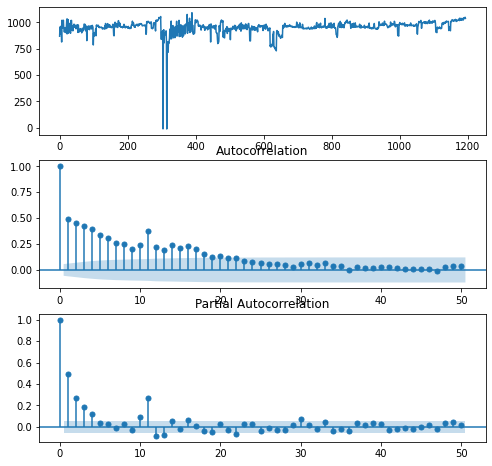

In [6]:
visualize_ts(x2_104)

In [7]:
def predict_arima(ts, params, split, status=True):
  tr_ts = ts[: split]
  te_ts = ts[split :]
  predictions = []
  for i in np.arange(te_ts.index.start, te_ts.index.stop):
    model_fit = fit_arima(tr_ts, params, summary = False)
    output = model_fit.forecast()
    predictions.append(output.values[0])
    tr_ts = tr_ts.append(pandas.DataFrame([te_ts.loc[i, te_ts.columns[0]]], columns=tr_ts.columns), ignore_index=True)
    if status:
      print(i, "-","Predicted:", output[0][0], ", Expected:", te_ts.loc[i, te_ts.columns[0]])
  error = calculate_mae(te_ts, predictions)
  print("Mean Absolute Error:", error)
  return error

First Strategy: Check Autocorrelation and Partial Autocorrelation Functions  
- Obtain p and q parameters by observing the Autocorrelation and Partial Autocorrelation Functions
- Requires user input

Model 1: ARIMA(4, 0, 0)

In [8]:
# Partial Autocorrelation Function
p = 4
# Autocorrelation Function
q = 0

error_1 = predict_arima(x2_104, (p, 0, q), 1000, status=False)

Mean Absolute Error: 31.013029846564063


Model 2: ARIMA(11, 0, 0)

In [9]:
# Partial Autocorrelation Function
p = 11
# Autocorrelation Function
q = 0

error_2 = predict_arima(x2_104, (p, 0, q), 1000, status=False)

Mean Absolute Error: 30.764230776828676


Second Strategy: Exaustive Parameter Search  
- Calculates Akaike Information Criterion for all combinations of parameters (up to given values of p and q)
- Does not require user input

In [10]:
def test_params(ts, limit_p, limit_q, itr, model_name="arima", s=0):
  aics = np.zeros((limit_p, limit_q))
  #aiccs = np.zeros((limit_p, limit_q))
  bics = np.zeros((limit_p, limit_q))
  for i in range(limit_p):
    for j in range(limit_q):
      if model_name == "arima":
        model = ARIMA(ts, order=(i, itr, j))
      elif model_name == "sarima":
        model = SARIMAX(ts, seasonal_order=(i, itr, j, s), initialization="approximate_diffuse")
      model_fit = model.fit()
      aics[i, j] = model_fit.aic
      #aiccs[i, j] = model_fit.aicc
      bics[i, j] = model_fit.bic
  fig, ax = plt.subplots(1, 2, figsize=(20, 16))
  ax[0].imshow(aics, cmap="copper")
  ax[1].imshow(bics, cmap="copper")
  for i in range(limit_p):
    for j in range(limit_q):
      text = ax[0].text(j, i, round(aics[i, j]), ha="center", va="center", color="w")
      text = ax[1].text(j, i, round(bics[i, j]), ha="center", va="center", color="w")
  plt.show()
  return aics, bics

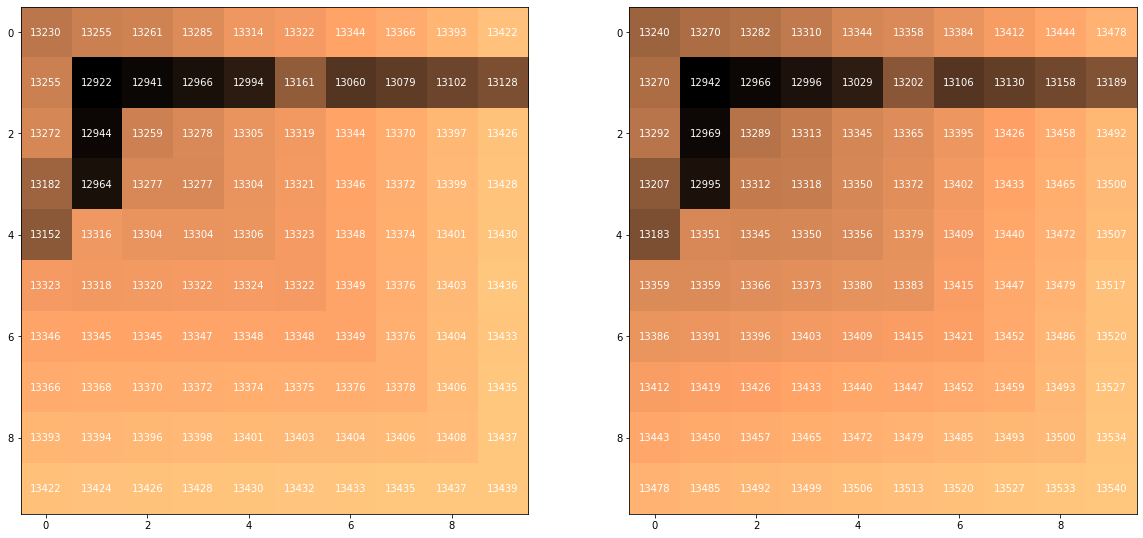

In [11]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  aics, bics = test_params(x2_104, 10, 10, 0, model_name="sarima", s=5)

In [12]:
p, q = np.unravel_index(aics.argmin(), aics.shape)
error_3 = predict_arima(x2_104, (p, 0, q), 1000, status=False)

Mean Absolute Error: 30.730861332091322


In [13]:
p, q = np.unravel_index(bics.argmin(), bics.shape)
error_4 = predict_arima(x2_104, (p, 0, q), 1000, status=False)

Mean Absolute Error: 30.730861332091322


Third Strategy: Exaustive Parameter Search with Minimum Value Plot  
- Calculates Akaike Information Criterion for all combinations of parameters (up to given values of p and q)
- Plots Akaike Information Criterion of each new minimum value
- Requires User Input

In [14]:
# Plot evolution of minimum criteria over parameter search
# Evolution is not sorted by number of parameters
def test_params_min_plot(ts, limit_p, limit_q, itr, model_name="arima", s=0):
  # Parameters of minimums
  params_aic = []
  params_bic = []
  # Minimums of each criteria
  mins_aic = []
  mins_bic = []
  # Minimum value for each criteria
  current_min_aic = None
  current_min_bic = None
  for i in range(limit_p + 1):
    for j in range(limit_q + 1):
      if model_name == "arima":
        model = ARIMA(ts, order=(i, itr, j))
      elif model_name == "sarima":
        model = SARIMAX(ts, seasonal_order=(i, itr, j, s), initialization="approximate_diffuse")
      model_fit = model.fit()
      current_aic = model_fit.aic
      current_bic = model_fit.bic
      # Check for new minimum AIC
      if current_min_aic is None or current_min_aic > current_aic:
        current_min_aic = current_aic
        params_aic.append(str((i, j)))
        mins_aic.append(current_aic)
      # Check for new minimum BIC
      if current_min_bic is None or current_min_bic > current_bic:
        current_min_bic = current_bic
        params_bic.append(str((i, j)))
        mins_bic.append(current_bic)
  fig, ax = plt.subplots(1, 2, figsize=(20, 8))
  ax[0].plot(np.arange(len(mins_aic)), mins_aic)
  ax[0].set_xticks(np.arange(len(mins_aic)))
  ax[0].set_xticklabels(params_aic)
  ax[1].plot(np.arange(len(mins_bic)), mins_bic)
  ax[1].set_xticks(np.arange(len(mins_bic)))
  ax[1].set_xticklabels(params_bic)
  plt.show()

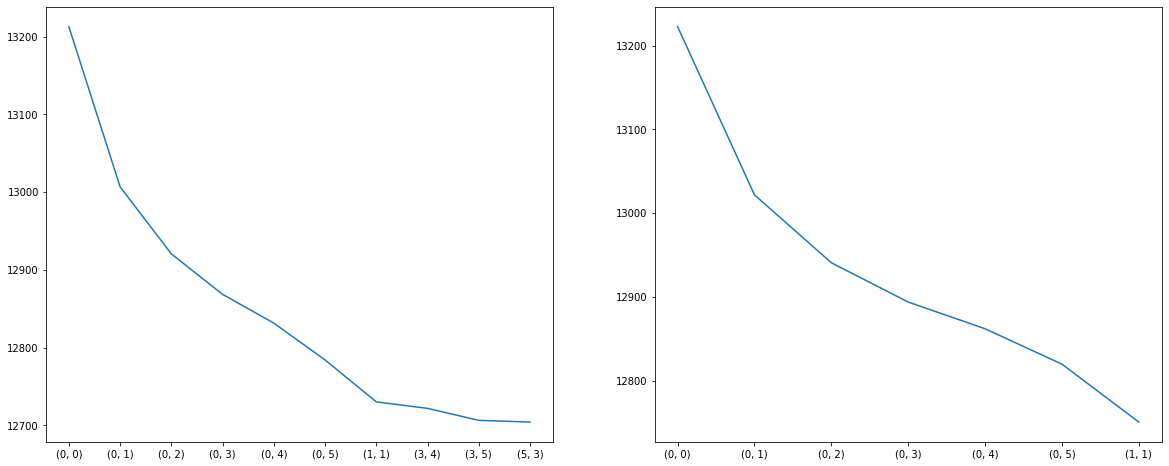

In [15]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    test_params_min_plot(x2_104, 5, 5, 0)

In [16]:
p, q = 1, 1
error_5 = predict_arima(x2_104, (p, 0, q), 1000, status=False)

Mean Absolute Error: 30.730861332091322


In [17]:
# Generates all possible combinations of two numbers whose sum is n
def combinations_sum(n):
  combinations = []
  limit = round((n // 2) + (n % 2))
  for i in range(n, limit - 1, -1):
    combinations.append((i, n - i))
    combinations.append((n - i, i))
  return combinations

#print(combinations_sum(10))

In [18]:
# Uses combinations of two numbers in order to parse in ascending order of parameters
def test_params_min_plot_ver_2(ts, limit_param, itr, model_name="arima", s=0):
  # Parameters of minimums
  params_aic = []
  params_bic = []
  # Minimums of each criterion
  mins_aic = []
  mins_bic = []
  # Minimum value for each criterion
  current_min_aic = None
  current_min_bic = None
  for i in range(limit_param):
    for comb in combinations_sum(i + 1):
      p, q = comb
      if model_name == "arima":
        model = ARIMA(ts, order=(p, itr, q))
      elif model_name == "sarima":
        model = SARIMAX(ts, seasonal_order=(p, itr, q, s), initialization="approximate_diffuse")
      model_fit = model.fit()
      current_aic = model_fit.aic
      current_bic = model_fit.bic
      # Check for new minimum AIC
      if current_min_aic is None or current_min_aic > current_aic:
          current_min_aic = current_aic
          params_aic.append(str(comb))
          mins_aic.append(current_aic)
      # Check for new minimum BIC
      if current_min_bic is None or current_min_bic > current_bic:
          current_min_bic = current_bic
          params_bic.append(str(comb))
          mins_bic.append(current_bic)
  print(params_aic)
  fig, ax = plt.subplots(1, 2, figsize=(20, 8))
  ax[0].plot(np.arange(len(mins_aic)), mins_aic)
  ax[0].set_xticks(np.arange(len(mins_aic)))
  ax[0].set_xticklabels(params_aic)
  ax[1].plot(np.arange(len(mins_bic)), mins_bic)
  ax[1].set_xticks(np.arange(len(mins_bic)))
  ax[1].set_xticklabels(params_bic)
  plt.show()

['(1, 0)', '(2, 0)', '(1, 1)', '(4, 3)', '(3, 4)', '(5, 3)', '(3, 6)', '(8, 2)']


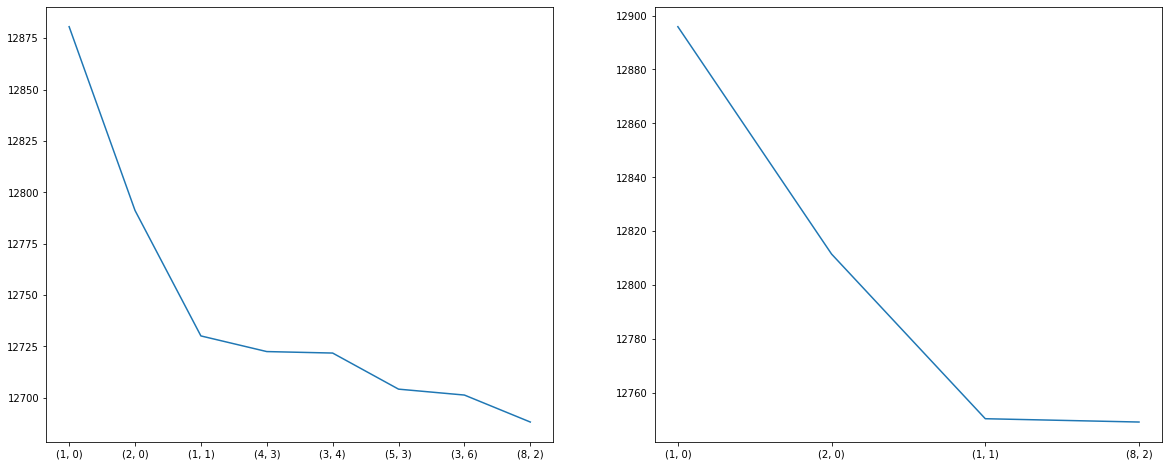

In [19]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    test_params_min_plot_ver_2(x2_104, 10, 0)

In [20]:
p, q = 5, 3
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    error_6 = predict_arima(x2_104, (p, 0, q), 1000, status=False)

Mean Absolute Error: 31.03496146157373


Second Dataset: covid19pt-data (SARIMA)

In [21]:
def fit_sarima(ts, params, summary=True):
  model = SARIMAX(ts, seasonal_order=params, initialization="approximate_diffuse")
  model_fit = model.fit(disp=0)
  if summary:
    print(model_fit.summary())
  return model_fit

def predict_sarima(ts, params, split, status=True):
  tr_ts = ts[: split]
  te_ts = ts[split :]
  predictions = []
  for i in np.arange(te_ts.index[0], te_ts.index[-1] + 1):
    model_fit = fit_sarima(tr_ts, params, summary = False)
    output = model_fit.forecast()
    predictions.append(output.values[0])
    tr_ts.loc[i] = te_ts.loc[i]
    if status:
      print(i, "-","Predicted:", output.values[0], ", Expected:", te_ts.loc[i])
  error = calculate_mae(te_ts, predictions)
  print("Mean Absolute Error:", error)
  return predictions, error

def plot_predicted(ts, pr, split):
  plt.plot(np.arange(len(ts)), ts)
  plt.plot(np.arange(split, (split + len(pr))), pr, color='red')
  plt.show()

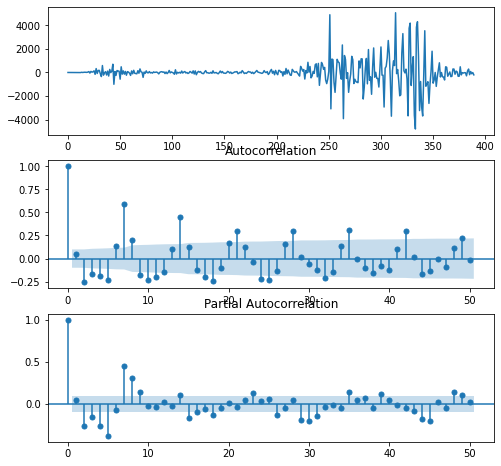

In [22]:
# Difference data 
cases = data_covid['confirmados_novos']
cases = cases.diff().dropna()
visualize_ts(cases)

# Differencing (already differenced)
d = 0
# Seasonal component (weekly)
s = 7

First Strategy: Check Autocorrelation and Partial Autocorrelation Functions  
- Obtain p and q parameters by observing the Autocorrelation and Partial Autocorrelation Functions
- Requires user input

Mean Absolute Error: 588.2112764892267


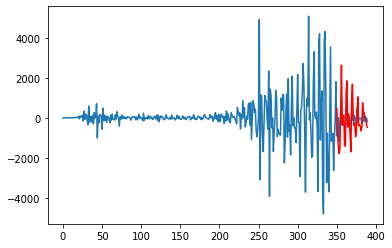

In [23]:
p, q = 5, 5

# Ignore Warnings
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  predicted, sarima_error_1 = predict_sarima(cases, (p, d, q, s), 350, status=False)
  plot_predicted(cases, predicted, 350)

Second Strategy: Exaustive Parameter Search  
- Calculates Akaike Information Criterion for all combinations of parameters (up to given values of p and q)
- Does not require user input

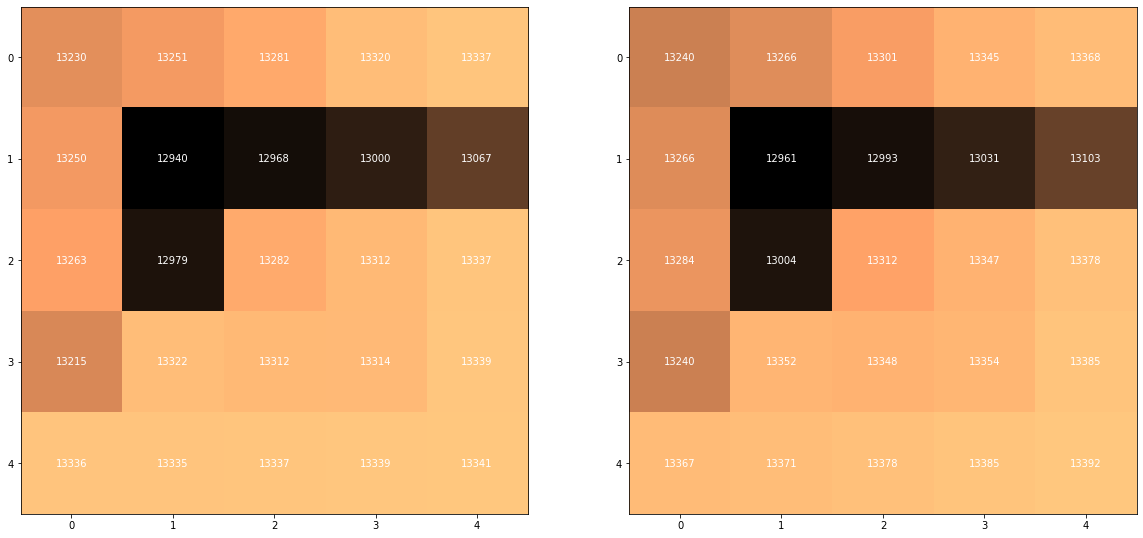

In [24]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    aics, bics = test_params(x2_104, 5, 5, 0, model_name="sarima", s=7)

1 1
Mean Absolute Error: 274.3953735300183


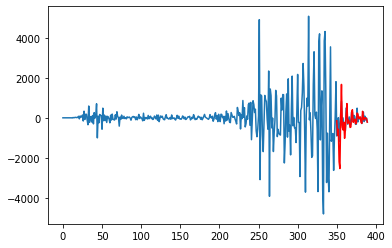

In [25]:
p, q = np.unravel_index(aics.argmin(), aics.shape)
print(p, q)
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  predicted, sarima_error_2 = predict_sarima(cases, (p, d, q, s), 350, status=False)
  plot_predicted(cases, predicted, 350)

Third Strategy: Exaustive Parameter Search with Minimum Value Plot  
- Calculates Akaike Information Criterion for all combinations of parameters (up to given values of p and q)
- Plots Akaike Information Criterion of each new minimum value
- Requires User Input

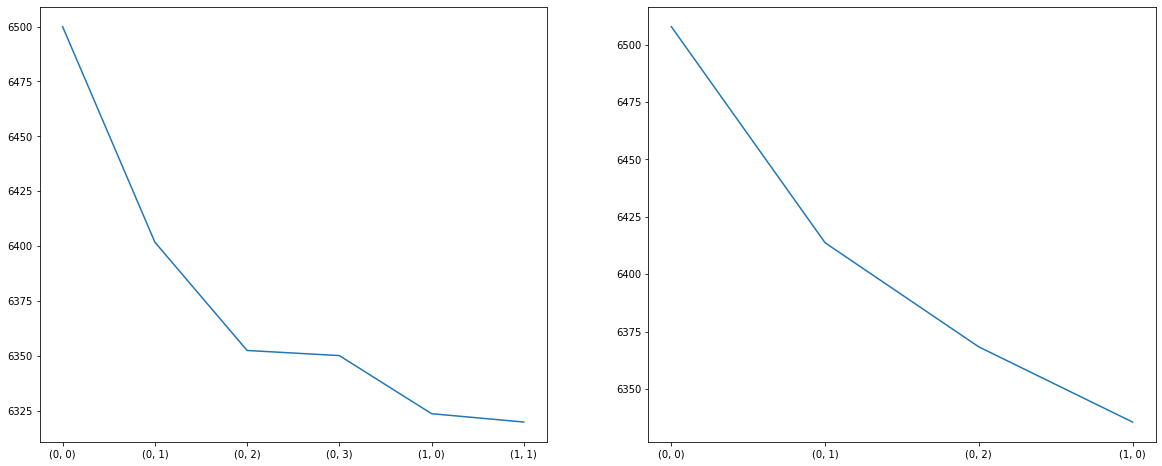

In [26]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  test_params_min_plot(cases, 10, 10, 0, model_name="sarima", s=7)

['(1, 0)', '(1, 1)']


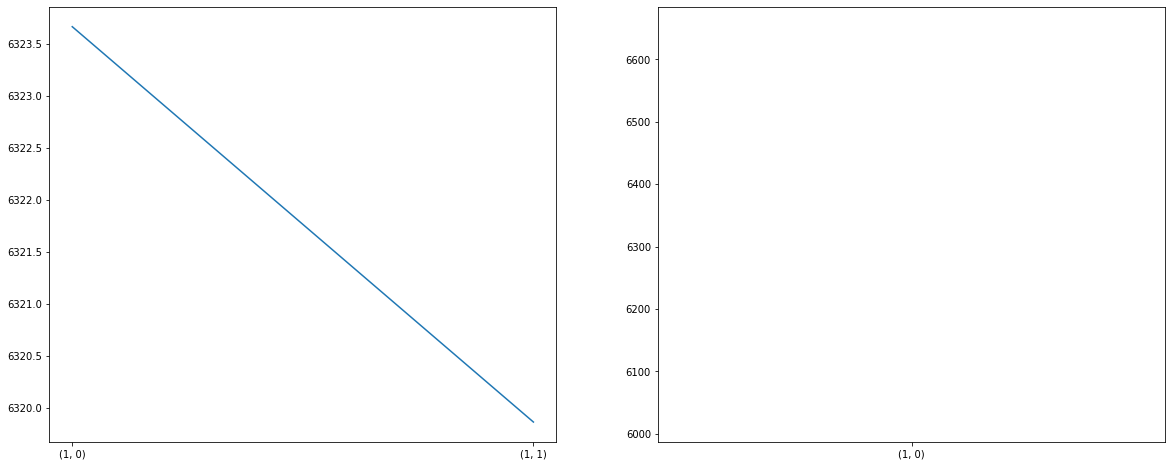

In [27]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  test_params_min_plot_ver_2(cases, 10, 0, model_name="sarima", s=7)

Third Dataset: Gas Furnace Data (VAR)

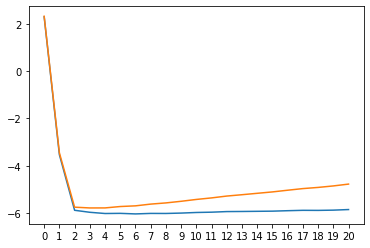

In [28]:
def plot_order(data, limit=10):
  model = VAR(data)
  res = model.select_order(maxlags=limit)
  fig, ax = plt.subplots()
  ax.plot(np.arange(limit + 1), res.ics['aic'])
  ax.plot(np.arange(limit + 1), res.ics['bic'])
  ax.set_xticks(np.arange(limit + 1))

plot_order(data_gas_furnace, limit=20)

Sanity Check

In [29]:
arparams = np.array([0.75, -0.25, 0.5])
maparams = np.array([0.65, 0.35])

ar = np.r_[1, -arparams]
ma = np.r_[1, maparams]

y = arma_generate_sample(ar, ma, 250)

In [30]:
y = pandas.DataFrame(y)
adf_test(y)

-----------------
0
ADF Value: -1.079387781590951
P-Value: 0.7232214392746281
Critical Values:
1% -3.457437824930831
5% -2.873459364726563
10% -2.573122099570008


In [31]:
y = y.diff().dropna()
y = y.reset_index()[0]
y = y.to_frame()
adf_test(y)

-----------------
0
ADF Value: -7.8765637288213535
P-Value: 4.826458966542484e-12
Critical Values:
1% -3.457437824930831
5% -2.873459364726563
10% -2.573122099570008


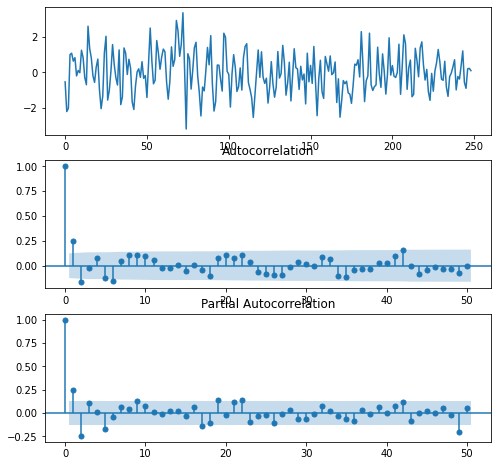

In [32]:
visualize_ts(y.values)

In [33]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  arima_error = predict_arima(y, (3, 0, 2), 150, status=False)

Mean Absolute Error: 0.8778408633826262


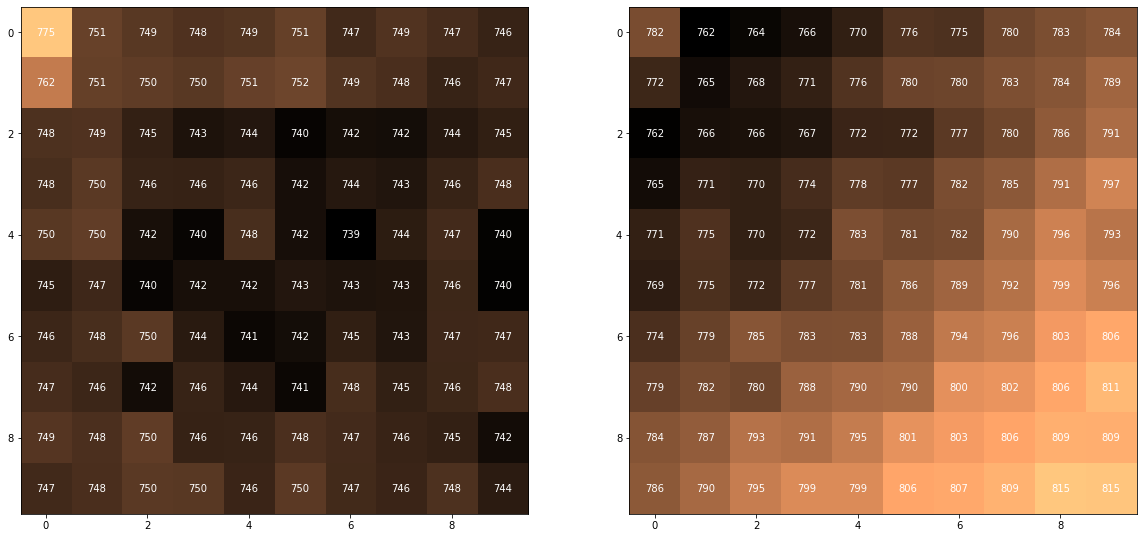

In [34]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  aics, bics = test_params(y, 10, 10, 0, model_name="arima", s=0)

In [40]:
p1, q1 = np.unravel_index(aics.argmin(), aics.shape)
p2, q2 = np.unravel_index(bics.argmin(), bics.shape)
print("Expected parameters: 3 and 2")
print("Estimated parameters (AIC):", p1, "and", q1)
print("Estimated parameters (BIC):", p2, "and", q2)

Expected parameters: 3 and 2
Estimated parameters (AIC): 4 and 6
Estimated parameters (BIC): 0 and 1


In [41]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  arima_error = predict_arima(y, (p1, 0, q1), 150, status=False)

Mean Absolute Error: 0.8932391090024827


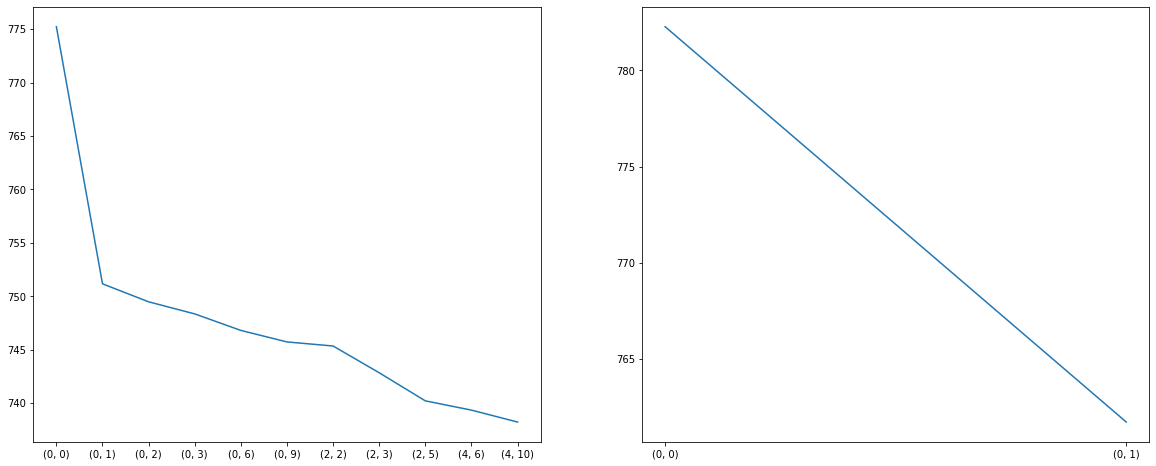

In [37]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  test_params_min_plot(y, 10, 10, 0, model_name="arima", s=0)

['(1, 0)', '(0, 1)', '(2, 0)', '(3, 0)', '(2, 2)', '(5, 0)', '(2, 3)', '(4, 2)', '(5, 2)', '(2, 5)', '(4, 6)', '(4, 10)', '(8, 11)', '(8, 12)']


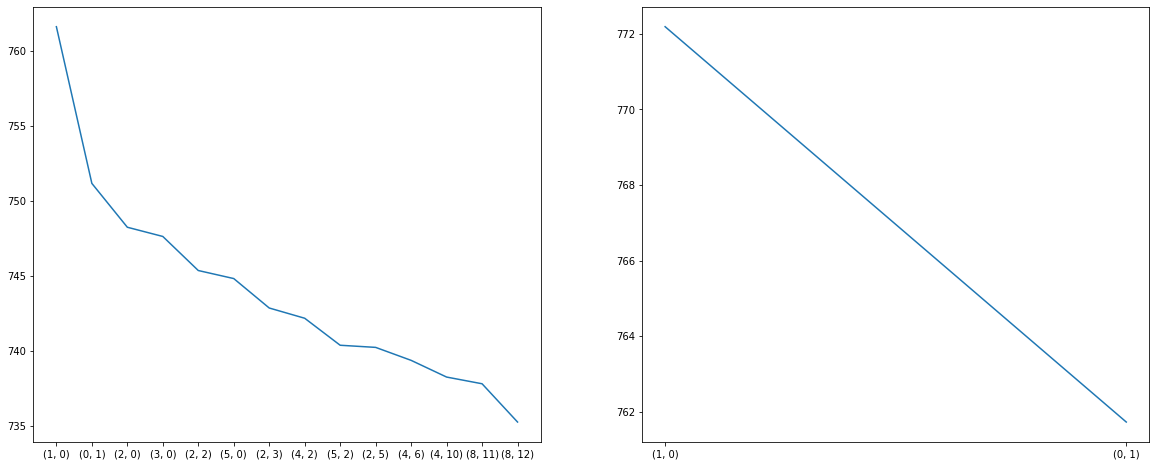

In [38]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  test_params_min_plot_ver_2(y, 20, 0, model_name="arima", s=0)